# Loan prediction: Leakage Detection and Prevention

##
This notebook performs pre-processing of the loan data with a focus on identifying and preventing various types of data leakage that could artificially inflate model performance, and performing experiments, showing the problems that come with leakages.

## Leakage Types to Monitor

1. Data-Induced Leakage
Label definition that makes prediction trivial (e.g., "Current" status correlates with recent issue dates).

2. Label Leakage
Post-outcome columns such as payments, collections, settlement amounts, or hardship flags that directly reveal the target variable.

3. Preprocessing Leakage
Fitting imputers, scalers, or encoders on the full dataset before train-test split, which leaks information from the test set into training.

4. Split-Related Leakage
Using random split on time-dependent data instead of proper temporal split, allowing future information to leak into training.

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pipeline.train import train_catboost_memory_optimized, prepare_catboost_data, build_model_pipeline
from pipeline.features import infer_feature_types
from pipeline.clean import parse_month_year, basic_clean_inplace
from full_data_loader import load_full_dataset_chunked
from scipy.stats import ttest_ind
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report, log_loss
)
from pipeline.config import LeakageSpec, iter_leakage_columns,CleaningSpec

### In the next cell I dropped text columns for the following reasons:
#### Text columns (desc, emp_title, title) require NLP/text processing.
#### They have high cardinality and high missingness.
#### Using them would require specialized feature engineering (like TF-IDF, embeddings).
#### including these would add complexity and reduce interpretability for a structured-feature baseline.
#### To keep the model simple, interpretable, and leakage-free, we exclude these free-text columns.
#### Risk if kept:
#### Very heavy memory
#### Model may learn artifacts or implicit hints about outcomes embedded in text.

We exclude the columns desc, emp_title, and title. These are high-cardinality text fields that require NLP and often carry a risk of borrower-induced leakage (e.g., descriptions mentioning early payoff intents). We use chunked loading to handle 2.26 million rows within memory limits.

In [140]:
ACCEPTED_CSV = Path("../data/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv")

TEXT_COLS = ["desc", "emp_title", "title"]

all_columns = pd.read_csv(ACCEPTED_CSV, nrows=0).columns.tolist()
usecols_list = [c for c in all_columns if c not in TEXT_COLS]

df = load_full_dataset_chunked(
    ACCEPTED_CSV, 
    chunk_size=200_000, 
    usecols=usecols_list
)

Loading full dataset from ../data/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
Chunk size: 200,000 rows
  Loaded 999,988 rows...
  Loaded 1,999,973 rows...
Concatenating 12 chunks...
Memory: 4.13 GB -> 2.47 GB (40.3% reduction)
Total rows loaded: 2,260,668
Final memory usage: 2.47 GB


We start by defining a 3-class target: 0 (Paid), 1 (Default), and 2 (Transient states like Current or Late). This allows us to inspect the raw distribution of loan statuses before specializing the model.

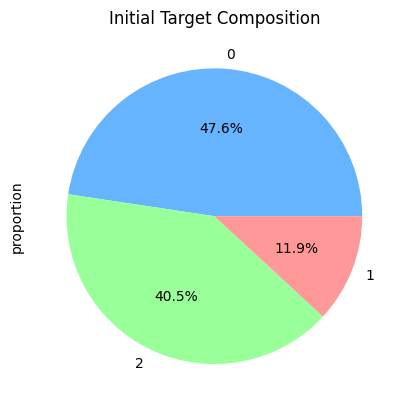

In [141]:
def initial_label(s):
    s = str(s).strip()
    if s in ["Fully Paid"]: return 0
    if s in ["Charged Off", "Default"]: return 1
    return 2

df['target_v1'] = df['loan_status'].apply(initial_label)
df['target_v1'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'])
plt.title("Initial Target Composition")
plt.show()

In [142]:
num_cols, cat_cols = infer_feature_types(df)
print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

Numeric: 115 | Categorical: 34


In [143]:
df['issue_d_dt'] = parse_month_year(df['issue_d'])
df['issue_year'] = df['issue_d_dt'].dt.year


#### Proof of Data-Induced Leakage The label "Current" only exists in significantly large amounts after 2017.
#### Randomly splitting this data allows the model to predict class 2 merely by knowing the loan is from 2018


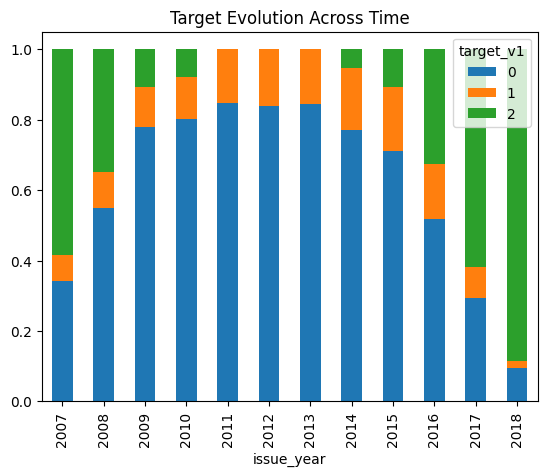

In [144]:
pd.crosstab(df['issue_year'], df['target_v1'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Target Evolution Across Time")
plt.show()

I did perform exprements on Random vs time splits, 
and that proved our dataset contains data induced leakage
Random Split Accuracy: 66% 

Time Split Accuracy: 6% (True performance on future drift)

In [145]:
cutoff_date = df['issue_d_dt'].quantile(0.8)
train_mask = df['issue_d_dt'] <= cutoff_date
test_mask = df['issue_d_dt'] > cutoff_date
print(cutoff_date)
print(f"Dataset Cutoff Date: {cutoff_date.date()}")
print(f"Pre-Cutoff (Train): {train_mask.sum():,} rows")
print(f"Post-Cutoff (Test): {test_mask.sum():,} rows")

2018-02-01 00:00:00
Dataset Cutoff Date: 2018-02-01
Pre-Cutoff (Train): 1,834,519 rows
Post-Cutoff (Test): 426,149 rows


In [146]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def run_combined_audit(df_sample, target_series):
    num_cols, cat_cols = infer_feature_types(df_sample)
    y = target_series.loc[df_sample.index]
    skip = ["target", "label", "loan_status"]

    num_data = []
    for col in num_cols:
        if any(s in col.lower() for s in skip): continue
        v0 = pd.to_numeric(df_sample.loc[y==0, col], errors='coerce').dropna()
        v1 = pd.to_numeric(df_sample.loc[y==1, col], errors='coerce').dropna()
        if len(v0)>10 and len(v1)>10:
            num_data.append({"Feature": col, "T-Stat": abs(ttest_ind(v0, v1, equal_var=False)[0])})
    
    cat_data = []
    for col in cat_cols:
        if any(s in col.lower() for s in skip): continue
        val = cramers_v(df_sample[col].astype(str), y.astype(str))
        cat_data.append({"Feature": col, "Cramér's V": val})

    return (pd.DataFrame(num_data).set_index("Feature").sort_values("T-Stat", ascending=False),
            pd.DataFrame(cat_data).set_index("Feature").sort_values("Cramér's V", ascending=False))

In [147]:
num_audit, cat_audit = run_combined_audit(df.sample(100000), df['target_v1'])

print("Top Numeric Leakers (T-Stat):")
display(num_audit.head(10))

print("\nTop Categorical Leakers (Cramér's V):")
display(cat_audit.head(10))


/home/wakeb/Wakeb-Projects--1/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:592: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_43402/1664351959.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


Top Numeric Leakers (T-Stat):


,T-Stat
Feature,
last_fico_range_high,236.129219
total_rec_prncp,180.658071
last_pymnt_amnt,179.437239
total_pymnt,106.635438
last_fico_range_low,106.594498
total_pymnt_inv,106.539994
recoveries,70.684802
collection_recovery_fee,66.117645
int_rate,62.183576



Top Categorical Leakers (Cramér's V):


,Cramér's V
Feature,
next_pymnt_d,0.706659
last_pymnt_d,0.676894
last_credit_pull_d,0.515780
issue_d,0.483378
debt_settlement_flag,0.332703
initial_list_status,0.245599
settlement_date,0.235462
settlement_status,0.235396
debt_settlement_flag_date,0.234681


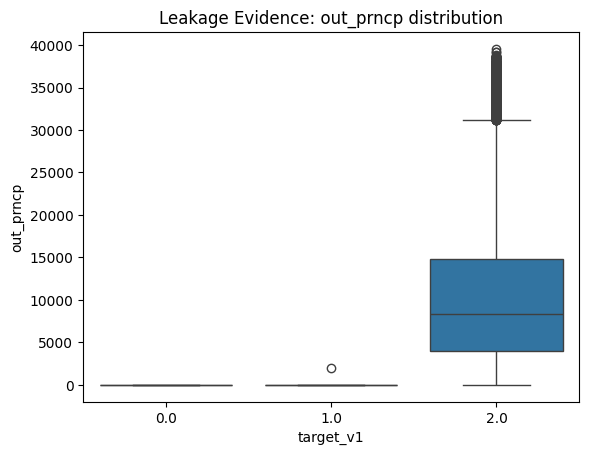

In [148]:
sns.boxplot(x='target_v1', y=pd.to_numeric(df['out_prncp'], errors='coerce'), data=df.sample(50000))
plt.title("Leakage Evidence: out_prncp distribution")
plt.show()

In [149]:
all_cols = df.columns.tolist()
leakage_cols = set(iter_leakage_columns(all_cols, LeakageSpec()))
forbidden = ["target", "label", "loan_status", "id", "url"]
meta_cols = {c for c in all_cols if any(f in c.lower() for f in forbidden)}

purge_list = leakage_cols | meta_cols | {"issue_d", "issue_d_dt", "issue_year"}

We filter to finalized outcomes in the Modern Era (2014+). This removes the noise found in the earlier drift analysis.

In [150]:
def get_final_outcome(s):
    s = str(s).strip()
    if "Paid" in s: return 0
    if any(x in s for x in ["Default", "Charged Off"]): return 1
    return -1

df_m = df[df['issue_d_dt'].dt.year >= 2014].copy()
y_bin_raw = df_m['loan_status'].apply(get_final_outcome)
df_clean = df_m[y_bin_raw != -1].copy()
y_bin = y_bin_raw[y_bin_raw != -1]

In [151]:
X_final = df_clean.drop(columns=[c for c in purge_list if c in df_clean.columns])
num_f, cat_f = infer_feature_types(X_final)

In [152]:
final_cutoff = df_clean['issue_d_dt'].quantile(0.8)
train_idx_f = df_clean['issue_d_dt'] <= final_cutoff
val_idx_f = df_clean['issue_d_dt'] > final_cutoff

X_tr, X_val = X_final.loc[train_idx_f], X_final.loc[val_idx_f]
y_tr, y_val = y_bin.loc[train_idx_f].values, y_bin.loc[val_idx_f].values

Joint vs single applications may have different default rates (e.g. joint apps might be better/worse risk depending on policies and co‑borrower strength

In [153]:
print("MISSING VALUE ANALYSIS AND HANDLING")

missing_pct = (df_clean.isna().mean() * 100).sort_values(ascending=False)

DROP_THRESHOLD = 95


INFORMATIVE_PATTERNS = ["joint", "sec_app", "hardship", "settlement"]

high_missing_95 = missing_pct[missing_pct >= 95].index.tolist()

# Separating what to drop vs what to keep
to_drop = [c for c in high_missing_95 if not any(p in c.lower() for p in INFORMATIVE_PATTERNS)]
kept_informative = [c for c in high_missing_95 if any(p in c.lower() for p in INFORMATIVE_PATTERNS)]

print(f"\nMissingness Summary:")
print(f"  Columns >= 95% missing: {len(high_missing_95)}")
if kept_informative:
    print(f"  Preserving {len(kept_informative)} informative columns despite high missingness (Joint & Financial Trouble)")

if to_drop:
    print(f"\nDropping {len(to_drop)} non-informative columns")
    X_final = X_final.drop(columns=to_drop, errors="ignore")
    
    num_f = [c for c in num_f if c in X_final.columns]
    cat_f = [c for c in cat_f if c in X_final.columns]



joint_cols = [c for c in X_final.columns if any(p in c.lower() for p in ["joint", "sec_app"])]
if joint_cols:
    X_final["has_joint_app"] = (~X_final[joint_cols].isna().all(axis=1)).astype(int)
    print(f"Created indicator: 'has_joint_app'")

hardship_cols = [c for c in X_final.columns if "hardship" in c.lower()]
if hardship_cols:
    X_final["has_hardship_history"] = (~X_final[hardship_cols].isna().all(axis=1)).astype(int)
    print(f"Created indicator: 'has_hardship_history'")

settlement_cols = [c for c in X_final.columns if "settlement" in c.lower()]
if settlement_cols:
    X_final["has_settlement_history"] = (~X_final[settlement_cols].isna().all(axis=1)).astype(int)
    print(f"Created indicator: 'has_settlement_history'")

remaining_missing = X_final.isna().sum()
print(f"\nFinal Missingness Summary:")
print(f"  Columns with any missing values: {(remaining_missing > 0).sum()}")
print("Note: Remaining missing values handled by CatBoost natively")

MISSING VALUE ANALYSIS AND HANDLING

Missingness Summary:
  Columns >= 95% missing: 38
  Preserving 33 informative columns despite high missingness (Joint & Financial Trouble)

Dropping 5 non-informative columns
Created indicator: 'has_joint_app'

Final Missingness Summary:
  Columns with any missing values: 50
Note: Remaining missing values handled by CatBoost natively


In [154]:
print("UPDATING TRAIN/VALIDATION SPLITS AFTER MISSING VALUE HANDLING")

X_tr, X_val = X_final.loc[train_idx_f], X_final.loc[val_idx_f]
y_tr, y_val = y_bin.loc[train_idx_f].values, y_bin.loc[val_idx_f].values

print(f"\nUpdated train/validation splits:")
print(f"  X_tr shape: {X_tr.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_tr shape: {y_tr.shape}")
print(f"  y_val shape: {y_val.shape}")


UPDATING TRAIN/VALIDATION SPLITS AFTER MISSING VALUE HANDLING

Updated train/validation splits:
  X_tr shape: (908149, 105)
  X_val shape: (209244, 105)
  y_tr shape: (908149,)
  y_val shape: (209244,)


#### Replaced the RAM-heavy Sklearn pipeline with a custom function (train_catboost_memory_optimized)
#### that loads data into CatBoost's efficient "Pool" format and immediately deletes the source DataFrames to prevent crashes.

###### for more reading: https://catboost.ai/docs/en/concepts/python-reference_pool

In [155]:
model_final = train_catboost_memory_optimized(
    X_tr.copy(), y_tr,
    X_val.copy(), y_val,
    numeric_cols=num_f, categorical_cols=cat_f
)

Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 0.6858166	test: 0.6866678	best: 0.6866678 (0)	total: 12ms	remaining: 12s
100:	learn: 0.6065257	test: 0.6185116	best: 0.6185116 (100)	total: 991ms	remaining: 8.82s
200:	learn: 0.6024360	test: 0.6137832	best: 0.6137832 (200)	total: 1.95s	remaining: 7.76s
300:	learn: 0.5998368	test: 0.6109852	best: 0.6109852 (300)	total: 2.92s	remaining: 6.78s
400:	learn: 0.5977908	test: 0.6089453	best: 0.6089453 (400)	total: 3.88s	remaining: 5.8s
500:	learn: 0.5960681	test: 0.6076165	best: 0.6076165 (500)	total: 4.85s	remaining: 4.83s
600:	learn: 0.5945977	test: 0.6066332	best: 0.6066332 (600)	total: 5.83s	remaining: 3.87s
700:	learn: 0.5932737	test: 0.6061244	best: 0.6061244 (700)	total: 6.79s	remaining: 2.9s
800:	learn: 0.5920562	test: 0.6058981	best: 0.6057

In [156]:
X_val_prep = prepare_catboost_data(X_val, num_f, cat_f)
print(classification_report(y_val, model_final.predict(X_val_prep)))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73    164921
           1       0.34      0.72      0.46     44323

    accuracy                           0.64    209244
   macro avg       0.61      0.67      0.60    209244
weighted avg       0.77      0.64      0.67    209244



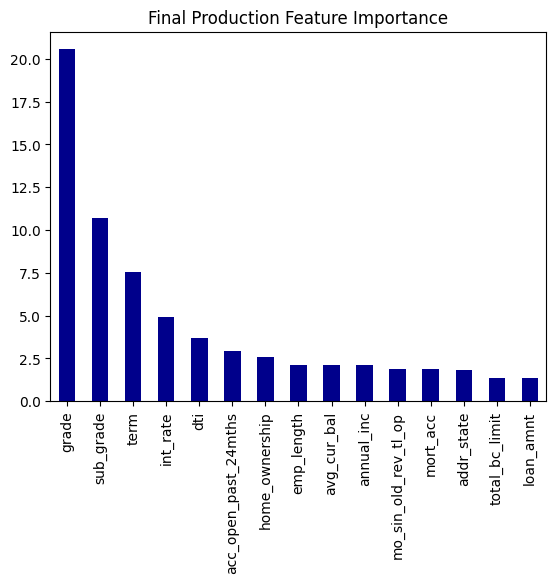

In [157]:
fi_final = pd.Series(model_final.get_feature_importance(), index=X_final.columns).sort_values(ascending=False)
fi_final.head(15).plot(kind='bar', color='darkblue')
plt.title("Final Production Feature Importance")
plt.show()

Lastly, I want to address each leakage found and how i handel it:
Data-Induced Leakage: I stopped predicting "Current" loans (which are proxies for time) and focused only on finalized outcomes (Paid vs Default)

Label Leakage: I explicitly dropped 43 columns (e.g. out_prncp, last_fico) identified by LeakageSpec as post-origination markers, also I dropped desc and title columns to prevent the model from learning "hidden" outcome hints written by borrowers.

Split-Related Leakage: I abandoned random splitting and implemented a strict 80/20 temporal Cutoff, training on the past and testing on the future.

Preprocessing Leakage: Pipeline Isolation: Statistics (imputation/scaling) are calculated within the training function, ensuring test-set means/medians never effected into training.

In [158]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from pipeline.features import infer_feature_types 

def run_binary_leakage_test(df_input, y_label, split_type="time", test_name="TEST"):
    print(f"\n{'='*20} {test_name} {'='*20}")
    
 
    forbidden_meta = ["loan_status", "target", "label", "issue_d_dt", "issue_year"]
    used_cols = [c for c in df_input.columns if not any(f in c.lower() for f in forbidden_meta)]
    df_filtered = df_input[used_cols].copy()
    

    dates = df.loc[df_filtered.index, 'issue_d_dt']
    
    if split_type == "time":
        cutoff = dates.quantile(0.8)
        train_idx = df_filtered.index[dates <= cutoff]
        test_idx = df_filtered.index[dates > cutoff]
    else:
        train_idx, test_idx = train_test_split(df_filtered.index, test_size=0.2, random_state=42)
    
    X_tr_test, X_val_test = df_filtered.loc[train_idx], df_filtered.loc[test_idx]
    y_tr_test, y_val_test = y_label.loc[train_idx], y_label.loc[test_idx]


    current_num, current_cat = infer_feature_types(df_filtered)
    
    model = train_catboost_memory_optimized(
        X_tr_test, y_tr_test, X_val_test, y_val_test,
        numeric_cols=current_num,
        categorical_cols=current_cat
    )


    X_val_prep = prepare_catboost_data(X_val_test, current_num, current_cat)
    y_proba = model.predict_proba(X_val_prep)[:, 1]
    y_pred = model.predict(X_val_prep).flatten()

    metrics = {
        'accuracy': accuracy_score(y_val_test, y_pred),
        'roc_auc': roc_auc_score(y_val_test, y_proba),
        'recall_default': recall_score(y_val_test, y_pred),
        'log_loss': log_loss(y_val_test, y_proba)
    }

    print(f"Metrics: {metrics}")
    print("\nConfusion matrix [0=Paid, 1=Default]:")
    print(confusion_matrix(y_val_test, y_pred))
    print("\nClassification report:")
    print(classification_report(y_val_test, y_pred))


def get_final_bin(s):
    s = str(s).strip()
    if "Paid" in s: return 0
    if any(x in s for x in ["Default", "Charged Off"]): return 1
    return -1

y_bin_raw = df['loan_status'].apply(get_final_bin)
mask_finished = (y_bin_raw != -1)
df_bin_subset = df[mask_finished].copy()
y_bin_active = y_bin_raw[mask_finished]


df_clean_bin = df_bin_subset.drop(columns=list(purge_list), errors='ignore')
run_binary_leakage_test(df_clean_bin, y_bin_active, split_type="time", test_name="CLEAN + TIME")


run_binary_leakage_test(df_clean_bin, y_bin_active, split_type="random", test_name="CLEAN + RANDOM")


run_binary_leakage_test(df_bin_subset, y_bin_active, split_type="time", test_name="LEAKY_PROBE + TIME")


==================== CLEAN + TIME ====================
Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 0.6862261	test: 0.6865312	best: 0.6865312 (0)	total: 12.3ms	remaining: 12.2s
100:	learn: 0.6103119	test: 0.6194394	best: 0.6194394 (100)	total: 1.11s	remaining: 9.93s
200:	learn: 0.6060504	test: 0.6150764	best: 0.6150764 (200)	total: 2.21s	remaining: 8.8s
300:	learn: 0.6034442	test: 0.6123607	best: 0.6123607 (300)	total: 3.31s	remaining: 7.67s
400:	learn: 0.6013491	test: 0.6104513	best: 0.6104513 (400)	total: 4.44s	remaining: 6.63s
500:	learn: 0.5996892	test: 0.6092438	best: 0.6092438 (500)	total: 5.46s	remaining: 5.44s
600:	learn: 0.5982929	test: 0.6082283	best: 0.6082283 (600)	total: 6.54s	remaining: 4.34s
700:	learn: 0.5970612	test: 0.6075228	best: 0.6075225 (699)	total: 7.66s	remain

# Future Work

In [89]:
from pipeline.tuning import run_optuna_study

best_hparams = run_optuna_study(
    X_tr, y_tr, X_val, y_val, 
    numeric_cols=num_f, 
    categorical_cols=cat_f, 
    n_trials=20
)

print("\nBest hyperparameters found by Optuna:")
print(best_hparams)

[I 2026-02-04 16:34:29,187] A new study created in memory with name: no-name-9f0ac56f-cbae-4546-87b6-cab42f0b67c1



Trial 0: testing params {'iterations': 1000, 'learning_rate': 0.07991114809039121, 'depth': 9, 'l2_leaf_reg': 4.373882478247214, 'random_strength': 2.0491138159325786, 'bagging_temperature': 0.05133985195847002, 'auto_class_weights': 'Balanced', 'verbose': False, 'random_seed': 42, 'early_stopping_rounds': 50, 'task_type': 'GPU', 'devices': '0', 'max_ctr_complexity': 1}


[W 2026-02-04 16:34:30,816] Trial 0 failed with parameters: {'learning_rate': 0.07991114809039121, 'depth': 9, 'l2_leaf_reg': 4.373882478247214, 'random_strength': 2.0491138159325786, 'bagging_temperature': 0.05133985195847002} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/wakeb/Wakeb-Projects--1/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/wakeb/Wakeb-Projects--1/project_1/pipeline/tuning.py", line 55, in <lambda>
    lambda trial: objective(trial, X_train, y_train, X_val, y_val, numeric_cols, categorical_cols),
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wakeb/Wakeb-Projects--1/project_1/pipeline/tuning.py", line 33, in objective
    X_train_prep = prepare_catboost_data(X_train, numeric_cols, categorical_cols)
                   ^^^^^^^^^^^

KeyboardInterrupt: 

In [88]:

import time
import pandas as pd
import matplotlib.pyplot as plt
from pipeline.train import (
    train_catboost_memory_optimized, 
    train_xgboost_memory_optimized,
    train_linear_baseline,
    evaluate_binary,
    prepare_catboost_data
)

catboost_tuned = {
    'learning_rate': 0.0671, 
    'depth': 8, 
    'l2_leaf_reg': 8.92, 
    'random_strength': 5.57, 
    'bagging_temperature': 0.38
}


xgboost_tuned = {
    'learning_rate': 0.0671,
    'max_depth': 8,
    'lambda': 8.92,
    'tree_method': 'gpu_hist'
}

models_to_test = {
    "CatBoost": (train_catboost_memory_optimized, catboost_tuned),
    "XGBoost": (train_xgboost_memory_optimized, xgboost_tuned),
    "Logistic Regression": (train_linear_baseline, {})
}

results = []

for name, (trainer, params) in models_to_test.items():
    print(f"\nBenchmarking {name}...")
    start_time = time.time()
    
    model = trainer(X_tr, y_tr, X_val, y_val, numeric_cols=num_f, categorical_cols=cat_f, custom_params=params)
    run_time = time.time() - start_time
    
    if name == "Logistic Regression":
        y_proba = model.predict_proba(X_val)[:, 1]
    elif "CatBoost" in name:
        X_val_p = prepare_catboost_data(X_val, num_f, cat_f)
        y_proba = model.predict_proba(X_val_p)[:, 1]
    elif "XGBoost" in name:
        import xgboost as xgb
        dval = xgb.DMatrix(X_val.copy(), enable_categorical=True)
        y_proba = model.predict(dval)

    metrics = evaluate_binary(y_val, y_proba)
    metrics.update({"Model": name, "Time (s)": run_time})
    results.append(metrics)


df_bench = pd.DataFrame(results).set_index("Model")
display(df_bench.sort_values("recall", ascending=False).style.background_gradient(cmap="Blues"))

df_bench[["Time (s)"]].plot(kind="barh", color='orange')
plt.title("Execution Speed")
plt.show()


Benchmarking CatBoost...
Memory optimization: Preparing training data...
Creating training pool...


KeyboardInterrupt: 